# Text Summarizer

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/Text Summarizer")

# Import the Libraries

In [3]:
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K 
from attention import AttentionLayer

Reading the Dataset

In [4]:
data = pd.read_csv('Reviews.csv')

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


We require only two columns from the original dataset.

In [6]:
data = data[['Summary', 'Text']]

In [7]:
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


Drop NA values and Duplicates

In [8]:
data.dropna(axis = 0, inplace = True)
data.drop_duplicates(subset = ['Text'], inplace = True)

In [9]:
data.shape

(393576, 2)

#Preprocessing

Using messy and uncleaned data is a potentially disastrous move. So, we'll remove all the unwanted characters from our dataset. 

Below is the dictionary that we'll use for expanding the contractions:

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                        "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                        "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                        "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                        "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                        "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                        "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", 
                        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [12]:
stop_words = set(stopwords.words('english'))

The function defined below performs the following tasks
* Convert each character to the lowercase
* Remove text inside parenthesis ()
* Contraction mapping
* Remove ('s)
* Remove all the characters except english alphabets
* Remove short words

In [13]:
def text_cleaner(text):
    result = text.lower()
    result = re.sub(r'\([^)]*\)','',result)
    result = re.sub('"', '', result)
    result = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in result.split(" ")])
    result = re.sub(r"'s\b'", '', result)
    result = re.sub("[^a-zA-z]", ' ', result)
    tokens = [w for w in result.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if(len(i) >= 3):
            long_words.append(i)
    result = " ".join(long_words).strip()
    return result

In [14]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [15]:
def summary_cleaner(text):
    result = text.lower()
    result = re.sub('"','', result)
    result = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in result.split(" ")])    
    result = re.sub(r"'s\b","",result)
    result = re.sub("[^a-zA-Z]", " ", result)
    tokens = result.split()
    long_words = []
    for i in tokens:
        if(len(i) >= 2):
            long_words.append(i)
    result = " ".join(long_words).strip()
    return result

In [16]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [17]:
print('Review : ', cleaned_text[0])
print('Summary :', cleaned_summary[0])

Review :  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary : good quality dog food


In [18]:
data['cleaned_summary'] = cleaned_summary
data['cleaned_text'] = cleaned_text
# drop empty rows
data['cleaned_summary'].replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

In [19]:
data.head()

,Summary,Text,cleaned_summary,cleaned_text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,good quality dog food,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertised,product arrived labeled jumbo salted peanuts p...
2,"""Delight"" says it all",This is a confection that has been around a fe...,delight says it all,confection around centuries light pillowy citr...
3,Cough Medicine,If you are looking for the secret ingredient i...,cough medicine,looking secret ingredient robitussin believe f...
4,Great taffy,Great taffy at a great price. There was a wid...,great taffy,great taffy great price wide assortment yummy ...


Remove long texts and sequences 

In [20]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

In [21]:
vis_text = pd.Series(text_word_count).value_counts()
vis_summary = pd.Series(summary_word_count).value_counts()

In [22]:
# print(vis_text[70:90])
# print(vis_summary[:20])

In [23]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 10):
        cnt = cnt+1
print(cnt / len(data['cleaned_summary']))

0.9794778159513571


In [24]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 80):
        cnt = cnt+1
print(cnt / len(data['cleaned_text']))

0.9135398097311264


We observe that 98% of the summaries have length below 10 and 91% of the texts have length below 80.

In [25]:
max_len_summary = 10
max_len_text = 80

In [26]:
cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_len_summary and len(cleaned_text[i].split()) <= max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
         
df = pd.DataFrame({'text':short_text,'summary':short_summary})

In [27]:
df.shape

(353585, 2)

Add the start of sequence and end of sequence tokens at the beginning and end of the summary respectively.

Here, "sostok" represents start of sequence token and "eostok" represents end of sequence tokens

In [28]:
df['summary'] = df['summary'].apply(lambda x : 'sostok ' + x + ' eostok')

In [29]:
for i in range(2):
  print("Review:",df['text'][i])
  print("Summary:",df['summary'][i])
  print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised eostok




Split the dataset into train, validation and test set.

In [30]:
# validation set
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']), test_size = 0.1, random_state = 0, shuffle = True)

In [31]:
# training and test set
x_tr, x_test, y_tr, y_test = train_test_split(x_tr, y_tr, test_size = 0.1, random_state = 0, shuffle = True)

In [32]:
print("Training set size:", x_tr.shape[0])
print("Validation set size:", x_val.shape[0])
print("Test set size:", x_test.shape[0])

Training set size: 286403
Validation set size: 35359
Test set size: 31823


## Tokenizer

* Text Tokenizer

It builds the vocabulary and converts a word sequence to an integer sequence.

In [33]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

Removing rare words:

Here, if no. of occurrences of a word is less than 4, then it is considered as a rare word.

total_count = size of the vocabulary

count = no. of rare words


In [34]:
count, total_count = 0, 0

for key, value in x_tokenizer.word_counts.items():
    total_count = total_count + 1
    if(value < 4):
        count = count + 1
    
print("Precentage of rare words in vocabulary:",(count / total_count) * 100)

Precentage of rare words in vocabulary: 64.7449858184765


In [35]:
x_tokenizer = Tokenizer(num_words = total_count - count)
x_tokenizer.fit_on_texts(list(x_tr))

# convert text to integer seqeunces
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

# pad sequences upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen = max_len_text, padding = 'post')
x_val = pad_sequences(x_val_seq, maxlen = max_len_text, padding = 'post')
x_test = pad_sequences(x_test_seq, maxlen = max_len_text, padding = 'post')

# +1 for the padding token
x_voc_size = len(x_tokenizer.word_counts) + 1
print('size of vocabulary', x_voc_size)

size of vocabulary 78977


* Summary Tokenizer

In [36]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [37]:
count, total_count = 0, 0

for key, value in y_tokenizer.word_counts.items():
    total_count = total_count + 1
    if(value < 4):
        count = count + 1
    
print("Precentage of rare words in vocabulary:",(count / total_count) * 100)

Precentage of rare words in vocabulary: 67.68920734437975


In [38]:
y_tokenizer = Tokenizer(num_words = total_count - count)
y_tokenizer.fit_on_texts(list(y_tr))

# convert text to integer seqeunces
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

# pad sequences upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = max_len_summary, padding = 'post')
y_val = pad_sequences(y_val_seq, maxlen = max_len_summary, padding = 'post')
y_test = pad_sequences(y_test_seq, maxlen = max_len_summary, padding = 'post')

# +1 for the padding token
y_voc_size = len(y_tokenizer.word_counts) + 1

Let us check whether the length of the training data equals the word count.

In [39]:
print(len(y_tr), y_tokenizer.word_counts['sostok'])

286403 286403


Delete the sequences that contains only start and end tokens

In [40]:
def delseq(y_sum):
    index = []
    for i in range(len(y_sum)):
        cnt = 0
        for j in y_sum[i]:
            if j != 0:      # 0 if padding 
                cnt = cnt+1
        if(cnt == 2):
            index.append(i)
    return index;

In [41]:
ind = delseq(y_tr)
y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [42]:
ind = delseq(y_val)
y_val = np.delete(y_val,ind, axis=0)
x_val = np.delete(x_val,ind, axis=0)

In [43]:
ind = delseq(y_test)
y_test = np.delete(y_test,ind, axis=0)
x_test = np.delete(x_test,ind, axis=0)

# MODEL

In [44]:
K.clear_session() 
latent_dim = 500 
embedding_dim = 300

In [45]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 

# Embedding Layer
# here, we are initializing our Embedding layer from scratch and learning its weights during training.
enc_emb_layer = Embedding(x_voc_size, embedding_dim, trainable = True)
enc_emb = enc_emb_layer(encoder_inputs) 

#encoder LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#encoder LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences = True,return_state = True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#encoder LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape = (None,)) 

# Embedding Layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim, trainable = True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#Decoder LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2) 
decoder_outputs, decoder_forwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [46]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      23693100    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

Here, I am using "sparse categorical cross-entropy" as the loss function. Since, it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [48]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
estop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

We’ll train the model on a batch size of 512 and validate it on the cross-validation set (which is 10% of our dataset)

In [50]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:, 1:] ,epochs = 50,callbacks = [estop], batch_size = 512, validation_data = ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
555/555 [==============================] - 788s 1s/step - loss: 2.7362 - val_loss: 2.3698
Epoch 2/50
555/555 [==============================] - 812s 1s/step - loss: 2.2508 - val_loss: 2.1381
Epoch 3/50
555/555 [==============================] - 817s 1s/step - loss: 2.0419 - val_loss: 1.9772
Epoch 4/50
555/555 [==============================] - 817s 1s/step - loss: 1.8840 - val_loss: 1.8870
Epoch 5/50
555/555 [==============================] - 817s 1s/step - loss: 1.7680 - val_loss: 1.8347
Epoch 6/50
555/555 [==============================] - 821s 1s/step - loss: 1.6724 - val_loss: 1.8060
Epoch 7/50
555/555 [==============================] - 818s 1s/step - loss: 1.5886 - val_loss: 1.7977
Epoch 8/50
555/555 [==============================] - 818s 1s/step - loss: 1.5105 - val_loss: 1.8011
Epoch 9/50
555/555 [==============================] - 817s 1s/step - loss: 1.4365 - val_loss: 1.8110
Epoch 00009: early stopping


Here, we will plot a few diagnostic plots to understand the behavior of the model over time:

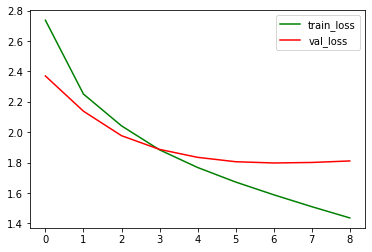

In [51]:
plt.plot(history.history['loss'], c = 'g', label='train_loss')
plt.plot(history.history['val_loss'], c = 'r', label='val_loss')
plt.legend()
plt.show()

Dictionary to convert the index to word for target and source vocabulary

In [52]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Inference:

In [53]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_hidden_state_input = Input(shape = (max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [54]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while(not stop_condition):
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
    return decoded_sentence

In [55]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
        newString = newString + reverse_target_word_index[i] + ' '
    return newString

In [56]:
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reverse_source_word_index[i] + ' '
    return newString

Let us predict output for the test set:

In [57]:
for i in range(5):
  print("Review:", seq2text(x_test[i]))
  print("Original summary:", seq2summary(y_test[i]))
  print("Predicted summary:", decode_sequence(x_test[i].reshape(1, max_len_text)))
  print("\n")

Review: amazing san marzano tomatoes unbeatable price try making homemade pizza wow good remember use salt pepper spices unadulterated unlike canned tomatoes 
Original summary: great tomatoes great price 
Predicted summary:  best tomato sauce


Review: product really good raise blood sugar give star cereal good hand tried ordering save shipping company let charge shipping item ordered companies amazon split cost box together save shipping fees shipping cost cereal worth ordering get something similar close live cannot get anything like live sadly say shipping makes total price compared amount product get something probably order 
Original summary: great product not so great shipping price 
Predicted summary:  good cereal but


Review: panda bars candy husband remembers loving childhood become favorite mine year old son also arrived quickly wish ordered boxes rate eating gone within week panda bar main ingredients wheat flour find high fructose corn syrup consider brands like twizzlers 